In [12]:
library(tidyverse)
library(glmnet)
library(caret)  # for model evaluation
library(pROC)# AUC-ROC
library(ggplot2)
library(GGally)

In [34]:
# Load the data
dat = read_csv("../data/raw//heart_attack_south_africa.csv")

Rows: 100000 Columns: 20
── Column specification ───────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): Gender, Smoking_Status, Alcohol_Intake, Physical_Activity, Diabete...
dbl (10): Patient_ID, Age, Cholesterol_Level, Blood_Pressure_Systolic, Blood...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Analyse and visualize pairwise correlation across all potential risk factors

Patient_ID,Age,Gender,Cholesterol_Level,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Smoking_Status,Alcohol_Intake,Physical_Activity,Obesity_Index,⋯,Family_History_Heart_Disease,Diet_Quality,Stress_Level,Heart_Attack_History,Medication_Usage,Triglycerides_Level,LDL_Level,HDL_Level,Heart_Attack_Outcome,new_SBP
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,76,Female,156,94,79,No,High,Sedentary,35.2,⋯,No,Good,High,No,No,264,141,65,0,57.59524
2,39,Female,160,185,88,No,Low,Sedentary,21.3,⋯,No,Average,Medium,No,Yes,150,81,42,0,68.09823
3,85,Male,254,173,113,Yes,Moderate,Highly Active,32.0,⋯,No,Good,Low,No,No,220,124,70,1,105.98708
4,45,Female,261,187,65,No,High,Sedentary,36.4,⋯,Yes,Average,Low,No,Yes,141,56,38,1,52.70508
5,48,Male,206,189,84,No,Low,Active,26.6,⋯,No,Good,High,No,No,221,186,26,0,68.49288
6,27,Female,228,136,100,No,Low,Active,28.7,⋯,No,Average,Medium,No,Yes,130,145,26,0,97.15065


Patient_ID,Age,Gender,Cholesterol_Level,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Smoking_Status,Alcohol_Intake,Physical_Activity,Obesity_Index,⋯,Family_History_Heart_Disease,Diet_Quality,Stress_Level,Heart_Attack_History,Medication_Usage,Triglycerides_Level,LDL_Level,HDL_Level,Heart_Attack_Outcome,new_SBP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,76,2,156,94,79,0,3,1,35.2,⋯,0,3,3,0,0,264,141,65,0,57.59524
2,39,2,160,185,88,0,1,1,21.3,⋯,0,2,2,0,1,150,81,42,0,68.09823
3,85,1,254,173,113,1,2,3,32.0,⋯,0,3,1,0,0,220,124,70,1,105.98708
4,45,2,261,187,65,0,3,1,36.4,⋯,1,2,1,0,1,141,56,38,1,52.70508
5,48,1,206,189,84,0,1,2,26.6,⋯,0,3,3,0,0,221,186,26,0,68.49288
6,27,2,228,136,100,0,1,2,28.7,⋯,0,2,2,0,1,130,145,26,0,97.15065


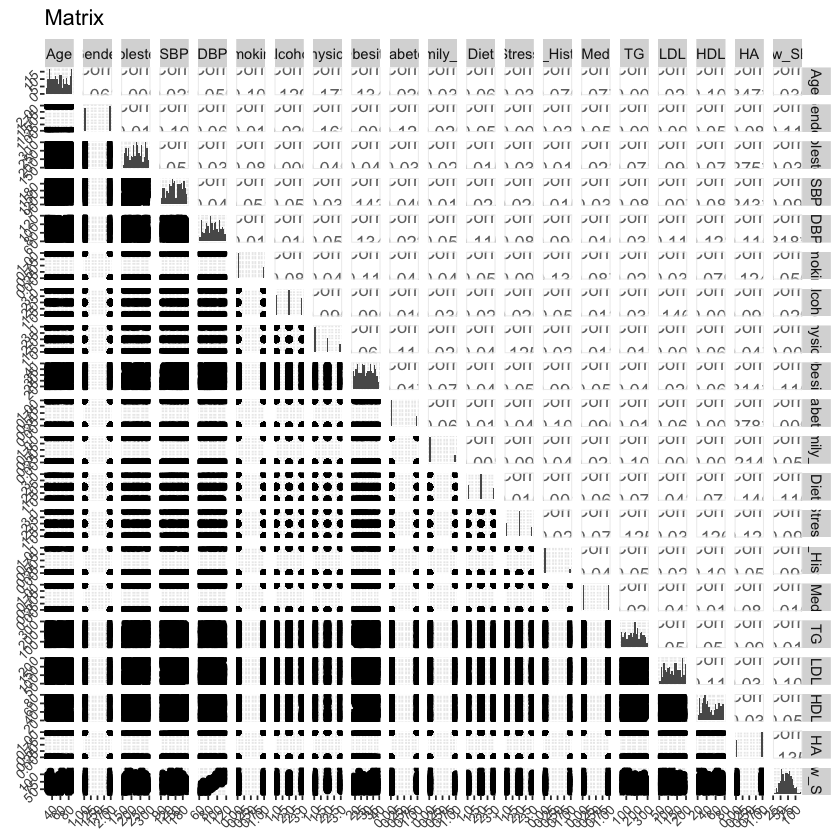

In [35]:
set.seed(123)
noise <- rnorm(n=100000, mean = 0, sd = 10) # Random noise
dat$new_SBP <- 0.8 * dat$Blood_Pressure_Diastolic + noise # SBP depends on DBP + noise
head(dat)
dat <- dat %>%
  mutate(
    Gender = recode(Gender, "Male" = "1", "Female" = "2"),
    Diabetes_Status = recode(Diabetes_Status, "No" = "0", "Yes" = "1"),
    Family_History_Heart_Disease = recode(Family_History_Heart_Disease, "No" = "0", "Yes" = "1"),
    Heart_Attack_History = recode(Heart_Attack_History, "No" = "0", "Yes" = "1"),
    Medication_Usage = recode(Medication_Usage, "No" = "0", "Yes" = "1"),
    Smoking_Status = recode(Smoking_Status, "No" = "0", "Yes" = "1"),
    Diet_Quality = recode(Diet_Quality, "Poor" = "1", "Average" = "2", "Good" = "3"),
    Stress_Level = recode(Stress_Level, "Low" = "1", "Medium" = "2", "High" = "3"),
    Alcohol_Intake = recode(Alcohol_Intake, "Low" = "1", "Moderate" = "2", "High" = "3"),
    Physical_Activity = recode(Physical_Activity, "Sedentary" = "1", "Active" = "2", "Highly Active" = "3")
  ) %>% 
  mutate(
    across(
      c(Gender, Diabetes_Status, Family_History_Heart_Disease, Heart_Attack_History,
        Medication_Usage, Smoking_Status, Diet_Quality, Stress_Level, Alcohol_Intake,
        Physical_Activity),
      as.numeric
    )
  )
head(dat)
dat = as.data.frame(dat) %>% na.omit()
colnames(dat) = c("Patient_ID","Age","Gender","Cholesterol",
                  "SBP","DBP","Smoking","Alcohol",
                  "Physical","Obesity","Diabetes","Family_HA",
                  "Diet","Stress","HA_History","Med",
                  "TG","LDL","HDL","HA","new_SBP")

cor = cor(dat[, !names(dat) %in% "Patient_ID"], use = "complete.obs")

set.seed(20250213)

p <- ggpairs(dat[sample(nrow(dat), 200),!colnames(dat)%in%c("Patient_ID")], diag = list(continuous = wrap("barDiag", bins = 20)),title="Matrix")
for(i in 1:p$nrow) {
  for(j in 1:p$ncol) {
    p[i, j] <- p[i, j] + theme(axis.text.x = element_text(angle = 45, hjust = 1,size = 8),
                               axis.text.y = element_text(angle = 45, hjust = 1, size = 8))
  }
}

p


## Univariable regression analysis for each risk factor to identify those that are associated with heart attack outcome

In [21]:

# load data for prediction
raw  <- read_csv("../data/raw//heart_attack_south_africa.csv")
set.seed(1)
noise <- rnorm(nrow(raw), mean = 0, sd = 10) # Random noise
raw$new_BP <- 0.8 * raw$Blood_Pressure_Diastolic + noise # SBP depends on DBP + noise
glimpse(raw)

Rows: 100000 Columns: 20
── Column specification ───────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): Gender, Smoking_Status, Alcohol_Intake, Physical_Activity, Diabete...
dbl (10): Patient_ID, Age, Cholesterol_Level, Blood_Pressure_Systolic, Blood...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 100,000
Columns: 21
$ Patient_ID                   <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…
$ Age                          <dbl> 76, 39, 85, 45, 48, 27, 46, 77, 26, 54, 6…
$ Gender                       <chr> "Female", "Female", "Male", "Female", "Ma…
$ Cholesterol_Level            <dbl> 156, 160, 254, 261, 206, 228, 278, 272, 1…
$ Blood_Pressure_Systolic      <dbl> 94, 185, 173, 187, 189, 136, 171, 145, 10…
$ Blood_Pressure_Diastolic     <dbl> 79, 88, 113, 65, 84, 100, 76, 112, 62, 72…
$ Smoking_Status               <chr> "No", "No", "Yes", "No", "No", "No", "No"…
$ Alcohol_Intake               <chr> "High", "Low", "Moderate", "High", "Low",…
$ Physical_Activity            <chr> "Sedentary", "Sedentary", "Highly Active"…
$ Obesity_Index                <dbl> 35.2, 21.3, 32.0, 36.4, 26.6, 28.7, 22.5,…
$ Diabetes_Status              <chr> "No", "No", "Yes", "No", "No", "No", "No"…
$ Family_History_Heart_Disease <chr> "No", "No", "No", "Yes", "No", "No", "No"…
$ Diet_Quality

In [22]:
## Subset for modelling
d_subset <- raw %>%
    select(-c("Patient_ID")) %>%
    na.omit()
nrow(d_subset)
nrow(raw)

[1] 100000

[1] 100000

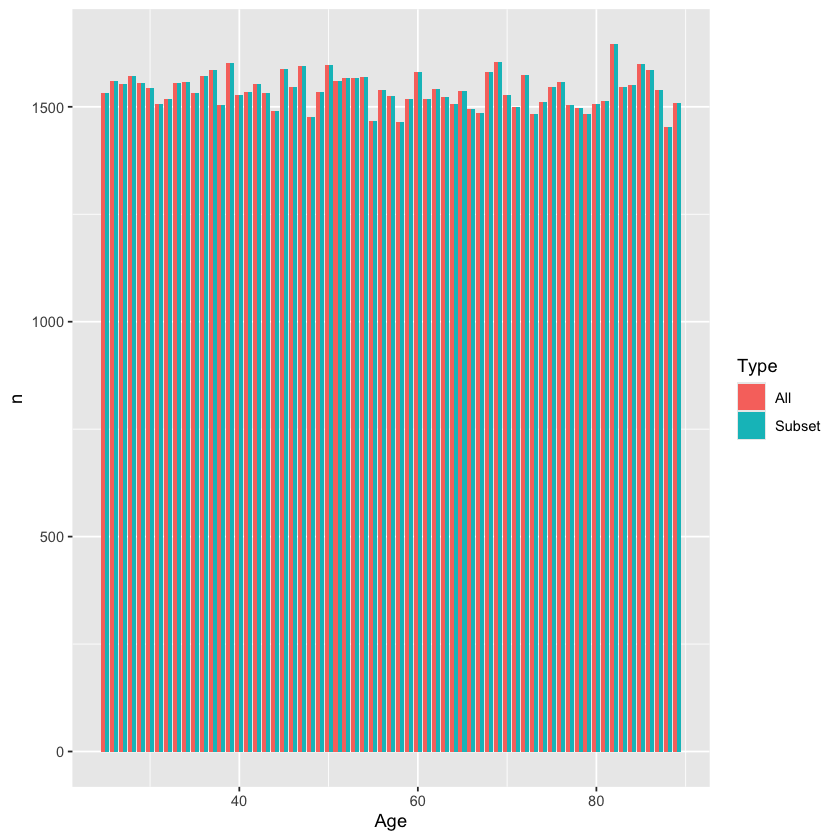

In [23]:
# check the distribution of age

d_ns <- bind_rows(
    raw %>% count(Age) %>% mutate(Type = "All"),
    d_subset %>% count(Age) %>% mutate(Type = "Subset")
)
ggplot(d_ns, aes(Age, n, fill = Type)) +
    geom_col(position = position_dodge())


In [24]:
# Data splitting for training and testing

young <- d_subset %>% filter(Age<55) # 46485
senior <-  d_subset %>% filter(Age>=55)

df <- young # potential for making a loop

set.seed(1) # Reproducibility and random number generation

train_idx <- sample(
    x = seq_len(nrow(df)),
    size = 0.7*nrow(df), replace = FALSE
)
d_train <- df %>% slice(train_idx) # train set, 32539
nrow(d_train)
d_test <- df %>% slice(-train_idx) # test set, 13946
nrow(d_test)

[1] 32539

[1] 13946

Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”


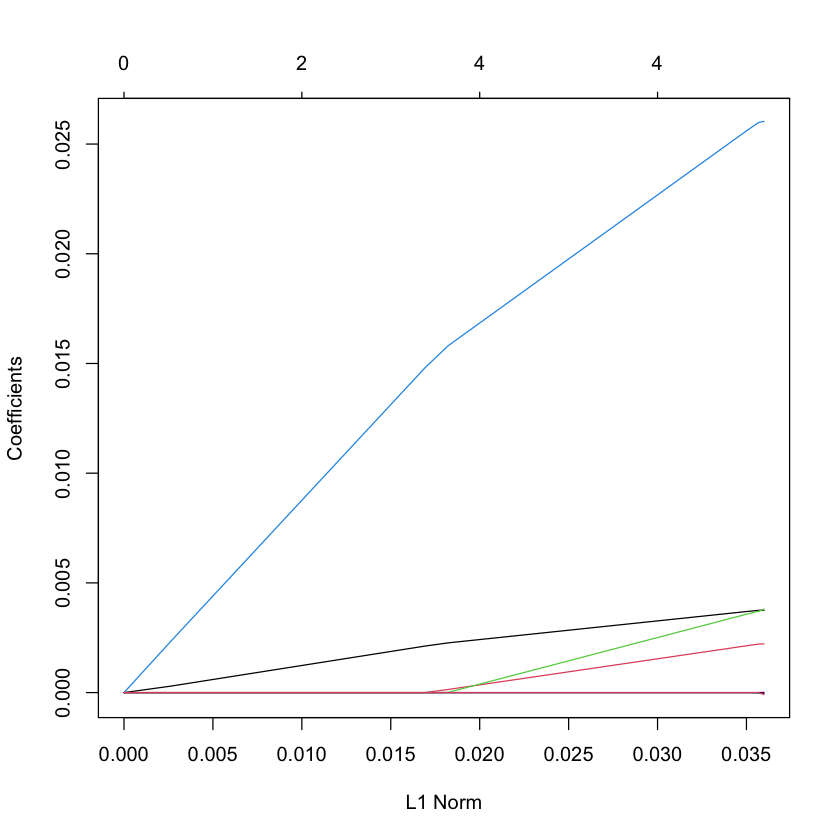

In [25]:
## Lasso regression
X <- as.matrix(d_train[,-which(names(d_train) == "Heart_Attack_Outcome")])
y <- d_train$Heart_Attack_Outcome
lasso_model <- glmnet(X,y, alpha = 1)

plot(lasso_model)


Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”
Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by co

[1] 0.001437124


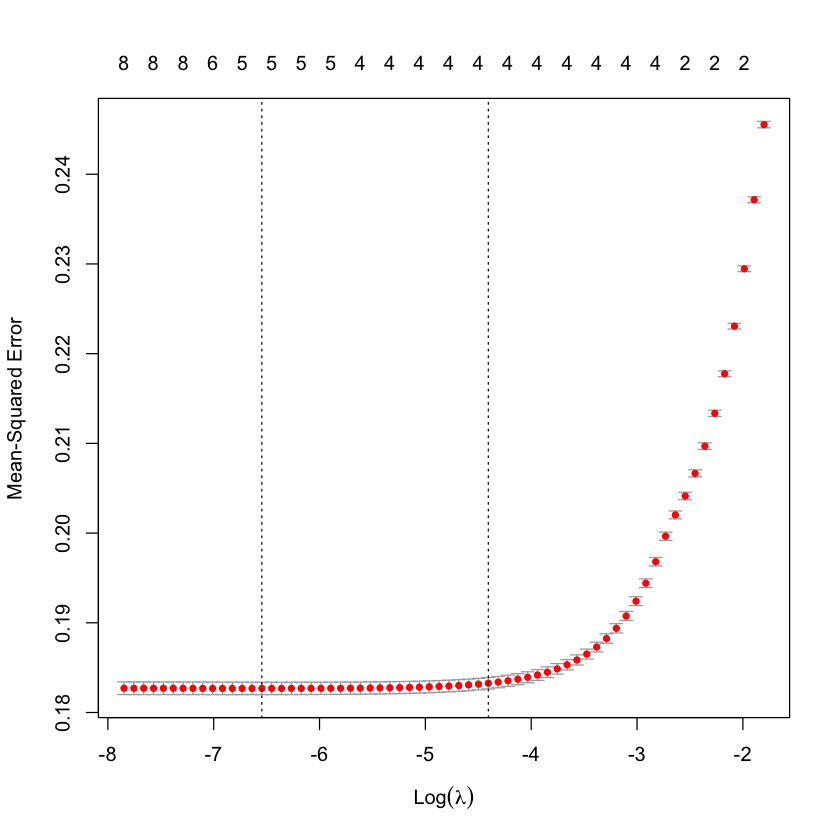

In [26]:
# choose the best lambda

set.seed(1) 
cv_model <- cv.glmnet(X,y, alpha = 1)
plot(cv_model)

best_lambda <- cv_model$lambda.min
print(best_lambda)

In [36]:
# use the best lambda to fit the Lasso model
lasso_best <- glmnet(X, y, alpha = 1, lambda = best_lambda)
coef(lasso_best)

Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”


20 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
(Intercept)                  -1.795026e+00
Age                           .           
Gender                        .           
Cholesterol_Level             3.733137e-03
Blood_Pressure_Systolic       2.188266e-03
Blood_Pressure_Diastolic      3.670898e-03
Smoking_Status                .           
Alcohol_Intake                .           
Physical_Activity             .           
Obesity_Index                 2.587287e-02
Diabetes_Status               .           
Family_History_Heart_Disease  .           
Diet_Quality                  .           
Stress_Level                  .           
Heart_Attack_History          .           
Medication_Usage              .           
Triglycerides_Level          -2.151181e-05
LDL_Level                     .           
HDL_Level                     .           
new_BP                        .           

In [29]:
## Prediction for the younger group

predictions <- predict(lasso_best, newx = as.matrix(d_test[,-which(names(d_test) == "Heart_Attack_Outcome")]))
y_true <- d_test$Heart_Attack_Outcome

y_pred_class <- ifelse(predictions > 0.5, 1, 0)
accuracy <- sum(y_pred_class == y_true) / length(y_true)
print(paste("Accuracy:", accuracy))

Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”


[1] "Accuracy: 0.718915818155744"


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 6173 2208
         1 1712 3853
                                          
               Accuracy : 0.7189          
                 95% CI : (0.7114, 0.7264)
    No Information Rate : 0.5654          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4226          
                                          
 Mcnemar's Test P-Value : 2.656e-15       
                                          
            Sensitivity : 0.7829          
            Specificity : 0.6357          
         Pos Pred Value : 0.7365          
         Neg Pred Value : 0.6924          
             Prevalence : 0.5654          
         Detection Rate : 0.4426          
   Detection Prevalence : 0.6010          
      Balanced Accuracy : 0.7093          
                                          
       'Positive' Class : 0               
                        

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.789936386538176"


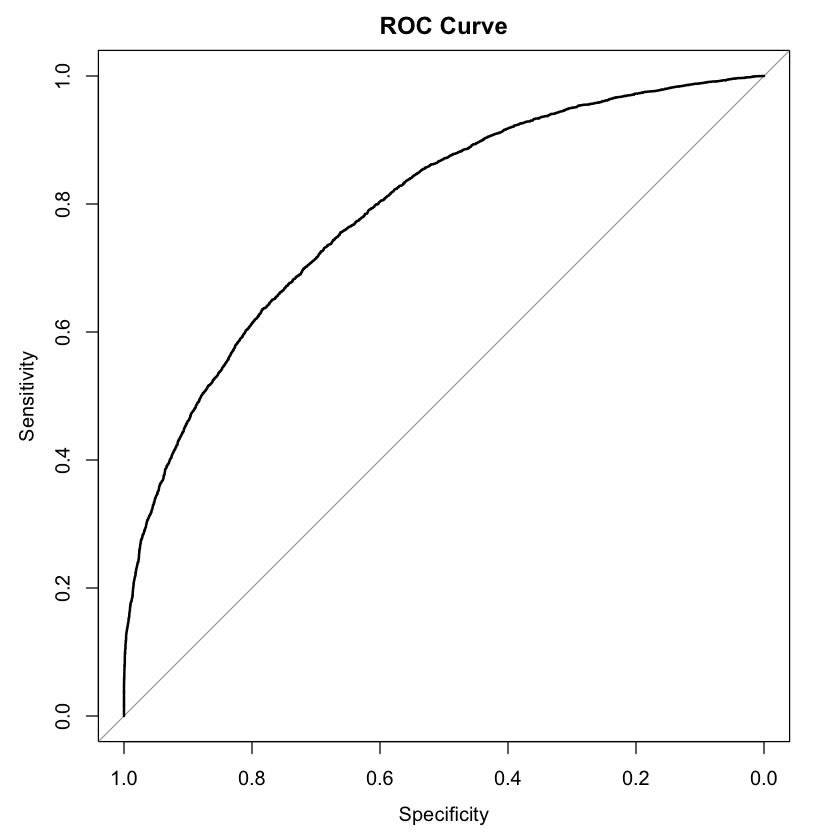

In [30]:

conf_matrix <- confusionMatrix(factor(y_pred_class), factor(y_true))
print(conf_matrix)

roc_obj <- roc(y_true, as.vector(predictions))
auc_value <- auc(roc_obj)
print(paste("AUC:", auc_value))


plot(roc_obj, main = "ROC Curve")

Warning message in cbind2(1, newx) %*% nbeta:
“NAs introduced by coercion”


[1] "Accuracy: 0.618761095020088"
Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 13310 18726
         1  1676 19803
                                          
               Accuracy : 0.6188          
                 95% CI : (0.6146, 0.6229)
    No Information Rate : 0.72            
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2984          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8882          
            Specificity : 0.5140          
         Pos Pred Value : 0.4155          
         Neg Pred Value : 0.9220          
             Prevalence : 0.2800          
         Detection Rate : 0.2487          
   Detection Prevalence : 0.5986          
      Balanced Accuracy : 0.7011          
                                          
       'Positive' Class : 0

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.793524262673886"


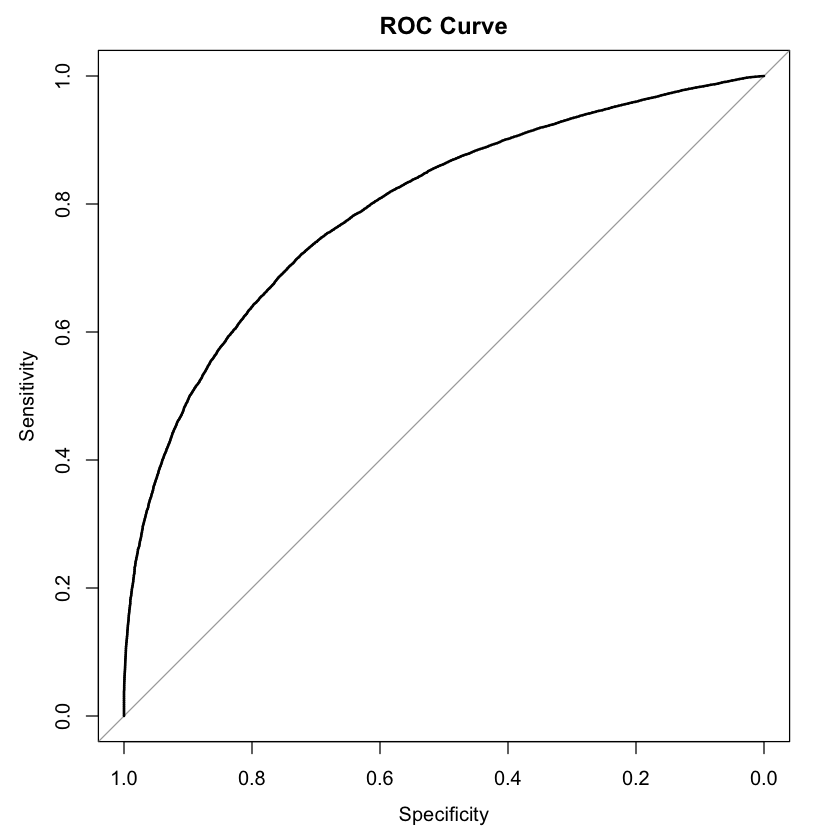

In [31]:

## Prediction for the older group
predictions <- predict(lasso_best, newx = as.matrix(senior[,-which(names(senior) %in% c("Heart_Attack_Outcome", "Patient_ID"))]))

y_true <- senior$Heart_Attack_Outcome

y_pred_class <- ifelse(predictions > 0.5, 1, 0)
accuracy <- sum(y_pred_class == y_true) / length(y_true)
print(paste("Accuracy:", accuracy))


conf_matrix <- confusionMatrix(factor(y_pred_class), factor(y_true))
print(conf_matrix)

roc_obj <- roc(y_true, as.vector(predictions))
auc_value <- auc(roc_obj)
print(paste("AUC:", auc_value))

plot(roc_obj, main = "ROC Curve")